### Importing all the necessary libraries.

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF

import nltk
wnl = nltk.WordNetLemmatizer()
from nltk.tokenize.treebank import TreebankWordDetokenizer

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import stop_words

### Reading the dataset.

In [2]:
input = pd.read_csv("abcnews-date-text.csv")

#input['Date'] = pd.to_datetime(input['Date'])
#input = input.sort_values(by='Date', ascending=True)
#input['Year'] = input['Date'].dt.year


docs  = input['headline_text'].values
print(docs[0:1])

['aba decides against community broadcasting licence']


In [3]:
year_list = [int(item/10000) for item in list(input['publish_date'])]

In [4]:
input['Year'] = year_list

### Model 1
#### After running multiple iterations, we have decided that this will be our baseline model. Any future model performance will be compared to this model.

In [5]:
#deciding the maximum number of features
no_features = 4000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df = 0.7, min_df = 5, max_features = no_features, stop_words = 'english',
                                  token_pattern = '[a-z][a-z]+')

#Vectorizing the news headlines
tfidf = tfidf_vectorizer.fit_transform(docs)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [6]:
no_topics = 14

# Run NMF
nmf = NMF(n_components = no_topics, random_state = 1, alpha = 0.1, l1_ratio = .5, init = 'nndsvd').fit(tfidf)

In [7]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 20

In [8]:
display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
interview extended michael john david nrl james ben andrew tim matt smith chris peter luke scott mark nathan ivan paul
Topic 1:
man jailed missing arrested dies guilty search attack stabbing child sex shot pleads charged accused shooting assault charges jail accident
Topic 2:
police probe investigate search missing hunt officer shooting death arrest seek say drug station body assault car fatal officers chase
Topic 3:
new zealand laws year york home centre deal hospital years president opens gets chief life named ceo rules mayor hope
Topic 4:
says minister mp pm trump labor union opposition expert wont chief government mayor group iraq report needed abbott need china
Topic 5:
rural national nsw news sa reporter country qld hour park friday exchange tuesday wednesday thursday monday drought tas doctors nrn
Topic 6:
court accused face faces told charges case high hears sex drug murder appeal alleged child supreme fronts assault appears rules
Topic 7:
govt water plan health wa urg

### Model 2
#### Baseline model + Lemmatization

In [12]:
docs_list = list(docs)

docs_tokens = []
for item in docs_list:
    docs_tokens.append(nltk.word_tokenize(item))

docs_lemma = []
for item in docs_tokens:
    docs_lemma.append([wnl.lemmatize(w) for w in item])

docs_detokens = []
for item in docs_lemma:
    docs_detokens.append(TreebankWordDetokenizer().detokenize(item))

input['Lemmatized_Text'] = docs_detokens
lemmatized_docs  = input['Lemmatized_Text'].values

In [35]:
# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df = 0.7, min_df = 5, max_features = no_features, stop_words = 'english',
                                  token_pattern = '[a-z][a-z]+')

#Vectorizing the news headlines
tfidf = tfidf_vectorizer.fit_transform(lemmatized_docs)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()


no_topics = 13
# Run NMF
nmf = NMF(n_components = no_topics, random_state = 1, alpha = 0.1, l1_ratio = .5, init = 'nndsvd').fit(tfidf)

display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
interview extended michael john david nrl james ben andrew smith matt chris peter mark nathan scott luke tim ivan matthew
Topic 1:
man charged murder jailed missing death stabbing guilty arrested attack dy sydney assault child shooting search pleads sex shot accused
Topic 2:
plan govt water nsw wa health qld report urged change cut government hospital boost job sa school service funding farmer
Topic 3:
police probe investigate missing search death officer hunt arrest shooting drug seek station assault raid charge body driver attack suspect
Topic 4:
new zealand law year home york deal set centre hospital hope open chief look president life ceo rule mayor named
Topic 5:
say ha minister need mp expert trump union wa pm labor public opposition wont time lawyer needed chief government mayor
Topic 6:
win cup world gold final award title open election aussie lead claim stage tour coast melbourne prize sydney record woman
Topic 7:
court face charge accused murder drug told case trial 

### Model 3
#### Baseline + Lemmatization + Additional stopwords

In [10]:
added_stopwords = frozenset(['group', 'need', 'say', 'blog', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday',
                             'saturday', 'needed', 'news'])
total_stopwords = stop_words.ENGLISH_STOP_WORDS.union(added_stopwords)

In [36]:
# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df = 0.7, min_df = 5, max_features = no_features, stop_words = total_stopwords,
                                  token_pattern = '[a-z][a-z]+')

#Vectorizing the news headlines
tfidf = tfidf_vectorizer.fit_transform(lemmatized_docs)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()


no_topics = 13
# Run NMF
nmf = NMF(n_components = no_topics, random_state = 1, alpha = 0.1, l1_ratio = .5, init = 'nndsvd').fit(tfidf)

display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
interview extended michael john david nrl james ben andrew smith matt chris peter mark nathan scott luke tim ivan matthew
Topic 1:
man charged murder jailed missing death stabbing guilty arrested attack dy assault sydney child shooting search pleads sex year shot
Topic 2:
govt wa nsw health report water qld change cut urged country government job hospital sa school hour service boost funding
Topic 3:
police probe investigate search missing officer death hunt arrest shooting drug seek station assault raid charge body driver attack suspect
Topic 4:
new year zealand law open york home centre deal set hope chief look president hospital life named ceo rule mayor
Topic 5:
win cup world open gold final australian award title lead aussie tour election stage woman claim record melbourne prize coast
Topic 6:
court face charge accused murder drug told case trial sex child woman high hears appeal alleged assault jail teen supreme
Topic 7:
rural national nsw reporter park sa qld doctor pre

### Model 4 - With Bigrams
#### Baseline + Lemmatization + Additional stopwords + Bigrams

In [27]:
no_features_BG = 6000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df = 0.7, min_df = 5, max_features = no_features_BG, stop_words = total_stopwords,
                                  token_pattern = '[a-z][a-z]+', ngram_range=(1,2))

#Vectorizing the news headlines
tfidf = tfidf_vectorizer.fit_transform(lemmatized_docs)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()


no_topics = 13
# Run NMF
nmf = NMF(n_components = no_topics, random_state = 1, alpha = 0.1, l1_ratio = .5, init = 'nndsvd').fit(tfidf)

def display_topics_BG(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(") (".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        
display_topics_BG(nmf, tfidf_feature_names, no_top_words)

Topic 0:
interview) (extended interview) (extended) (interview michael) (michael) (nrl interview) (interview david) (smith) (nrl) (david) (interview john) (scott) (john) (interview james) (james) (interview ben) (ben) (shane) (adam) (josh
Topic 1:
man) (charged) (man charged) (murder) (jailed) (death) (man jailed) (missing) (stabbing) (man dy) (arrested) (attack) (guilty) (assault) (dy) (sydney) (man arrested) (shooting) (missing man) (man accused
Topic 2:
govt) (wa) (water) (nsw) (report) (health) (change) (qld) (hospital) (cut) (job) (school) (sa) (government) (urged) (farmer) (boost) (service) (claim) (funding
Topic 3:
police) (probe) (investigate) (police investigate) (police probe) (officer) (search) (death) (missing) (police officer) (hunt) (police hunt) (arrest) (drug) (police search) (shooting) (police seek) (seek) (assault) (body
Topic 4:
new) (new zealand) (zealand) (year) (law) (new year) (open) (new york) (york) (centre) (new home) (deal) (new law) (president) (look) (home)

### Topic Trend Analysis

In [45]:
# Create Document - Topic Matrix
nmf_output = nmf.transform(tfidf)

# column names
topicnames = ["Topic" + str(i) for i in range(nmf.n_components)]

# index names
docnames = ["Document" + str(i) for i in range(len(lemmatized_docs))]

# Make the pandas dataframe
DocTop_df = pd.DataFrame(np.round(nmf_output, 4), columns=topicnames, index=docnames)

#DocTop_df['Year'] = input['Year'].values
DocTop_df.head(10)

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12
Document0,0.0,0.0,0.0014,0.0000,0.0,0.0000,0.0002,0.0000,0.0000,0.0,0.0000,0.0000,0.0000
Document1,0.0,0.0,0.0010,0.0004,0.0,0.0000,0.0000,0.0001,0.0000,0.0,0.0000,0.0001,0.0000
Document2,0.0,0.0,0.0006,0.0000,0.0,0.0000,0.0001,0.0000,0.0000,0.0,0.0000,0.0000,0.0000
Document3,0.0,0.0,0.0028,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0005,0.0001,0.0006
Document4,0.0,0.0,0.0008,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0003,0.0075
Document5,0.0,0.0,0.0000,0.0000,0.0,0.0208,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0000
Document6,0.0,0.0,0.0005,0.0000,0.0,0.0004,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0002
Document7,0.0,0.0,0.0004,0.0000,0.0,0.0011,0.0000,0.0000,0.0001,0.0,0.0000,0.0000,0.0000
Document8,0.0,0.0,0.0006,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0193,0.0002,0.0001
Document9,0.0,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0142,0.0,0.0000,0.0000,0.0000


In [46]:
#pd.DataFrame(nmf_output)
tvtv = nmf_output / nmf_output.sum(axis=1, keepdims=True)
Doc_Top_pd = pd.DataFrame(tvtv)

Doc_Top_pd['Year'] = input['Year'].values
Doc_Top_pd.head(10)

C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


,0,1,2,3,4,5,6,7,8,9,10,11,12,Year
0,0.0,0.0,0.874768,0.000000,0.0,0.000000,0.117615,0.000000,0.000000,0.0,0.007617,0.000000,0.000000,2003
1,0.0,0.0,0.642034,0.235291,0.0,0.000000,0.000000,0.057416,0.000000,0.0,0.000000,0.065258,0.000000,2003
2,0.0,0.0,0.882725,0.000000,0.0,0.000000,0.112087,0.000000,0.000000,0.0,0.005188,0.000000,0.000000,2003
3,0.0,0.0,0.695781,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.129808,0.023003,0.151408,2003
4,0.0,0.0,0.091677,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.036859,0.871464,2003
5,0.0,0.0,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,2003
6,0.0,0.0,0.437015,0.000000,0.0,0.323754,0.000000,0.000000,0.038100,0.0,0.000000,0.000000,0.201131,2003
7,0.0,0.0,0.215912,0.000000,0.0,0.683807,0.008941,0.000000,0.072236,0.0,0.000000,0.000000,0.019103,2003
8,0.0,0.0,0.027942,0.000000,0.0,0.000000,0.000000,0.000000,0.001420,0.0,0.959396,0.008038,0.003204,2003
9,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,2003


In [47]:
df = Doc_Top_pd.groupby("Year").sum()
df = df.transpose()
df['Topics'] = df.index
df.head(10)

Year,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,Topics
0,152.976115,181.749206,344.624558,271.238084,495.943858,1008.920281,2393.439904,3308.303545,2420.916862,3347.180922,3205.614031,2720.402695,1467.718395,870.397077,820.487263,682.246828,643.544486,0
1,2807.174761,3263.028064,3386.188750,2998.852075,4169.375128,4754.350126,4482.773929,4530.371188,4280.509241,4227.053494,4348.990126,3781.332911,4122.449640,3577.998651,2552.644676,2273.987074,2062.602152,1
2,30839.025910,35242.949417,35660.306264,33778.834896,38370.683288,38526.275657,35670.530152,33700.410778,36304.543482,41410.514158,43020.001588,38106.695451,36460.898597,29337.691061,22660.418418,18648.065588,15741.639068,2
3,3598.681519,4328.449511,4437.519948,3837.107142,4836.554603,4694.362150,4329.494039,4001.220370,3888.860672,3991.275937,4020.647069,3383.507899,3361.385242,2690.505580,2049.765928,1816.664467,1663.806693,3
4,2413.265260,2757.141853,2808.369107,2366.740720,2645.969710,2745.605981,2469.240636,2412.569476,2534.012617,2900.569839,3305.612388,3042.530570,3136.454540,2400.996914,1831.143154,1410.394434,1132.815545,4
5,5165.854828,5372.589228,4775.200851,4539.059807,4544.727620,4906.388659,4846.806753,5302.459465,5149.621020,5348.072450,4821.653664,5178.368787,4879.660985,3596.216629,2621.100264,2166.015959,1725.848258,5
6,1917.330494,2308.291135,2269.067525,2062.183162,2389.645785,1991.886701,1768.331071,1914.428911,1811.963597,2045.498561,2012.778676,1522.175567,1362.376625,956.858819,651.405863,486.567929,409.203200,6
7,3395.313514,3935.621262,3862.513256,3417.764518,4143.026776,4303.557415,4186.951557,4121.181844,3901.183421,4190.439668,4209.037632,3482.437510,3456.086801,2909.121177,2437.977050,1964.177551,1799.447470,7
8,2808.518976,2896.711648,2883.789610,2520.991201,2468.638583,2768.855330,2876.443795,2918.358442,2785.417343,3661.064604,4218.070666,4256.781998,4411.664680,3543.819117,3057.420646,2554.413460,2063.956633,8
9,734.435039,806.983874,1000.625348,922.274738,986.140334,1019.778119,816.519900,747.301699,901.769013,1463.169451,2584.865381,2735.586512,1944.362622,1475.503551,938.517545,648.322344,502.064311,9


In [48]:
def plot_bar_grid(row,col,cols):
    
    fig, axes = plt.subplots(nrows=row, ncols=col, figsize=(12,10))
    i = 0
    for ax in axes.flatten():
        sns.barplot(y = cols[i],x = 'Topics',ax= ax,data = df)
        ax.set_title(f'{cols[i]} vs Topics')
        ax.set_xticklabels(['T1','T2','T3','T4','T5','T6','T7','T8', 'T9', 'T10', 'T11', 'T12', 'T13'])
        i += 1
    
    # Display the figure object    
    fig
    plt.tight_layout()
    display()

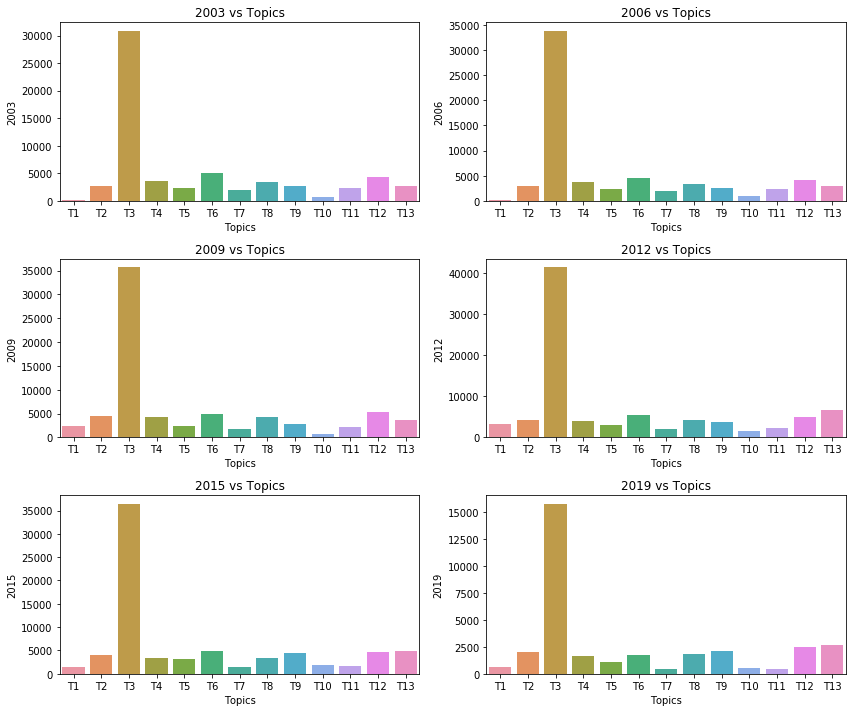

In [49]:
plot_bar_grid(3,2,[2003, 2006, 2009, 2012, 2015, 2019])